<a href="https://colab.research.google.com/github/R-Jin/bird-song-classifier/blob/main/bird_song_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare dataset location

In [12]:
from google.colab import drive

# Mount Google Drive
drive.flush_and_unmount()
drive.mount('/content/drive')

# Setup target directory
target_dir = "/content/drive/MyDrive/birdclef-2025"

Mounted at /content/drive


# Imports

In [13]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import librosa.display

# Constants

In [14]:
BATCH_SIZE = 32

SAMPLE_RATE = 32000

# Read dataset

In [4]:
train_df = pd.read_csv("/content/drive/MyDrive/birdclef-2025/train.csv")

unique_bird_species = train_df['primary_label'].nunique()
unique_song_types = train_df['type'].nunique()

print(f"Number of unique bird species: {unique_bird_species}")
print(f"Number of unique song types: {unique_song_types}")

Number of unique bird species: 206
Number of unique song types: 736


In [16]:
unwanted_labels = [
    'uncertain', 'frog', 'frogs', 'car', 'plane', 'wind', 'river', 'surf',
    'motor', 'insect', 'noise', 'background', 'voices', 'human', 'dog',
    'perro', 'cow', 'latido', 'engine', 'traffic', 'urban', 'música',
    'music', 'unknown', 'no idea', '?', 'nao', 'não', 'environmental',
    'ambient', 'dogs', 'bird in h', 'laughing', 'hits', 'chatter', 'mechanical', 'imitation',
]

canonical_labels = {
    'song': ['song', 'songs', 'full song', 'complete song', 'alternate song', 'display song', 'morning song', 'evening song', 'day song', 'dawn song', 'vesper song', 'nuptial song', 'predawn song'],
    'call': ['call', 'calls', 'typical call', 'short call', 'long call', 'flight call', 'begging call', 'alarm call', 'chase call', 'contact call', 'feeding call', 'distress call', 'display call', 'excited call', 'juvenile call'],
    'alarm call': ['alarm call', 'alarm calls', 'alarm', 'alarm whistle', 'alarm call?', 'alarm call in flight'],
    'flight call': ['flight call', 'calls in flight', 'call in flight', 'flight calls', 'take-off calls', 'take-off call'],
    'duet': ['duet', 'duet song', 'duet call', 'couple duet', 'song and duet', 'duetting'],
    'drum': ['drum', 'drumming', 'bill snap', 'bill snapping', 'wing beat', 'wing flaps', 'wing noise', 'wing flutter', 'wing flutters', 'wing sounds', 'wing whirr', 'wing whirrs', 'wing snaps', 'bill/wing snapping'],
    'subsong': ['subsong', 'subsong?', '"subsong"'],
    'trill': ['trill', 'trilled call', 'trill call', 'cooing trill'],
    'display': ['display', 'display song', 'display call', 'song during display flight', 'display song & instrumental wings noise'],
}


In [11]:
import re

unique_labels = []

song_labels = train_df['type'].unique().tolist()


for x in song_labels:
  results = re.findall(r"'([^']*)'", x)
  for result in results:
    if result not in unique_labels:
      unique_labels.append(result)

print(unique_labels)
print(len(unique_labels))

['', 'advertisement call', 'territorial call', 'flight call', 'chorus', 'uncertain', 'call', 'agressive call', 'song', 'alarm call', 'calls', 'flight calls', 'call (in flight)', 'song while displaying', 'begging call', 'young calling from the nest', 'call in flight', 'feeding call', '3 indiv', 'alarm call?', 'hatchling or nestling', 'drumming', 'klee series', 'canto', 'splash', 'partial song', 'nocturnal flight call', 'subsong', 'immature male', 'chase call', 'day song', '(flight?) calls', 'take-off calls', 'canto de voo', 'chamado', 'duet', 'flight song', 'call and song in flight', 'calls on takling flight', 'estridulación', 'frogs', 'contact calls', 'llamado de cría', 'musical calls', 'aberrant', 'duet song. calls', 'excited call', 'alarm calls', 'agitated calls', 'canto longo variado', 'call (siren call)', 'dueto', 'anfibios', 'bill rattle', 'wing beats', 'songs', 'couple duet', 'song with several variations. all sounds made by wtst.', 'rattle', 'music in far back', 'plane', 'wing n

In [6]:
#print(train_df['type'].unique())
print(train_df['primary_label'].unique())
print(len(train_df['primary_label'].unique()))

['1139490' '1192948' '1194042' '126247' '1346504' '134933' '135045'
 '1462711' '1462737' '1564122' '21038' '21116' '21211' '22333' '22973'
 '22976' '24272' '24292' '24322' '41663' '41778' '41970' '42007' '42087'
 '42113' '46010' '47067' '476537' '476538' '48124' '50186' '517119'
 '523060' '528041' '52884' '548639' '555086' '555142' '566513' '64862'
 '65336' '65344' '65349' '65373' '65419' '65448' '65547' '65962' '66016'
 '66531' '66578' '66893' '67082' '67252' '714022' '715170' '787625'
 '81930' '868458' '963335' 'amakin1' 'amekes' 'ampkin1' 'anhing' 'babwar'
 'bafibi1' 'banana' 'baymac' 'bbwduc' 'bicwre1' 'bkcdon' 'bkmtou1'
 'blbgra1' 'blbwre1' 'blcant4' 'blchaw1' 'blcjay1' 'blctit1' 'blhpar1'
 'blkvul' 'bobfly1' 'bobher1' 'brtpar1' 'bubcur1' 'bubwre1' 'bucmot3'
 'bugtan' 'butsal1' 'cargra1' 'cattyr' 'chbant1' 'chfmac1' 'cinbec1'
 'cocher1' 'cocwoo1' 'colara1' 'colcha1' 'compau' 'compot1' 'cotfly1'
 'crbtan1' 'crcwoo1' 'crebob1' 'cregua1' 'creoro1' 'eardov1' 'fotfly'
 'gohman1' 'grasa

In [ ]:
# Generated with gemini
# Prompt: Create data loaders

class BirdClefDataset(Dataset):
    def __init__(self, df, target_dir, audio_transform=None):
        self.df = df
        self.target_dir = target_dir
        self.audio_transform = audio_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = os.path.join(self.target_dir, "train_audio", row["primary_label"], row["filename"])
        try:
          waveform, sample_rate = torchaudio.load(audio_path)
        except:
          print(f"Error loading file {audio_path}")
          # Instead of returning None, return an empty tensor and a default label
          waveform = torch.empty((0,))
          label = "unknown"
          return waveform, label

        if self.audio_transform:
            waveform = self.audio_transform(waveform)

        label = row["primary_label"]
        return waveform, label

train_dataset = BirdClefDataset(train_df, target_dir)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Error loading file /content/drive/MyDrive/birdclef-2025/train_audio/555086/555086/XC882687.ogg
Error loading file /content/drive/MyDrive/birdclef-2025/train_audio/smbani/smbani/iNat371704.ogg
Error loading file /content/drive/MyDrive/birdclef-2025/train_audio/greegr/greegr/XC290048.ogg
Error loading file /content/drive/MyDrive/birdclef-2025/train_audio/gohman1/gohman1/XC119150.ogg
Error loading file /content/drive/MyDrive/birdclef-2025/train_audio/wbwwre1/wbwwre1/XC242762.ogg
Error loading file /content/drive/MyDrive/birdclef-2025/train_audio/socfly1/socfly1/XC793178.ogg
Error loading file /content/drive/MyDrive/birdclef-2025/train_audio/smbani/smbani/iNat340600.ogg
Error loading file /content/drive/MyDrive/birdclef-2025/train_audio/roahaw/roahaw/XC306862.ogg
Error loading file /content/drive/MyDrive/birdclef-2025/train_audio/yeofly1/yeofly1/XC552803.ogg
Error loading file /content/drive/MyDrive/birdclef-2025/train_audio/strcuc1/strcuc1/XC260419.ogg
Error loading file /content/drive/My

ParameterError: Input is too short (n=0) for frame_length=1

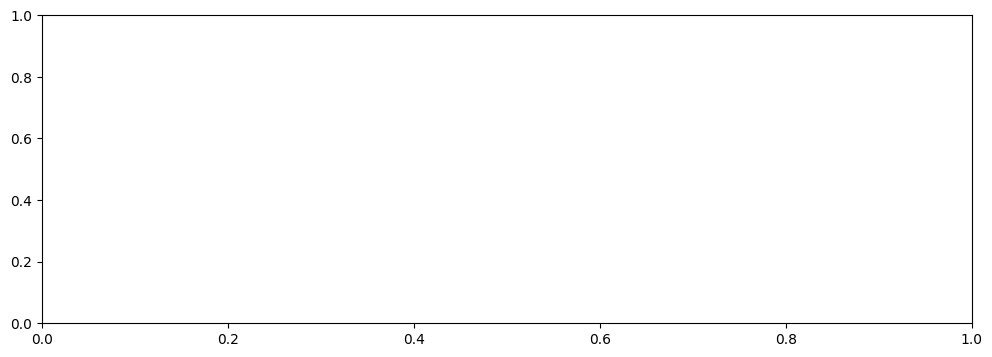

In [ ]:
# Generated with gemini
# prompt: Visualise one data sample as wave form

sample = next(iter(train_loader))

if sample is not None: # Check if the sample loaded correctly
  waveform, label = sample[0][0], sample[1][0] # Access first audio and label

  # Convert waveform to NumPy array if necessary
  waveform = waveform.numpy()

  # Plot the waveform
  plt.figure(figsize=(12, 4))
  librosa.display.waveshow(waveform, sr=32000)
  plt.title(f"Waveform of {label}")
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")
  plt.show()
else:
  print("Sample could not be loaded. Check file paths and loading procedure.")


In [ ]:
# Generated with Gemini
# prompt: Visualise one data sample as Mel spectrogram

import librosa
import librosa.display
import matplotlib.pyplot as plt

# Assuming 'waveform' and 'label' are defined from the previous code

if sample is not None:
  waveform, label = sample[0][0], sample[1][0]
  waveform = waveform.numpy()

  # Calculate the mel spectrogram
  mel_spec = librosa.feature.melspectrogram(y=waveform, sr=SAMPLE_RATE, n_mels=128)
  mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

  # Display the mel spectrogram
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(mel_spec_db, sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title(f'Mel Spectrogram of {label}')
  plt.tight_layout()
  plt.show()
else:
  print("Sample could not be loaded. Check file paths and loading procedure.")


# Neural network


In [ ]:
# Example NN from GPT

class BirdSongClassifier(nn.Module):
    def __init__(self, num_species, num_song_types):
        super(BirdSongClassifier, self).__init__()

        # Convolutional backbone (simple CNN for now)
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 1/2 size

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Output shape: [batch, 64, 1, 1]
        )

        # Shared feature layer
        self.shared_fc = nn.Linear(64, 128)

        # Output heads
        self.species_head = nn.Linear(128, num_species)
        self.song_type_head = nn.Linear(128, num_song_types)

    def forward(self, x):
        x = self.features(x)            # [B, 64, 1, 1]
        x = x.view(x.size(0), -1)       # [B, 64]
        x = F.relu(self.shared_fc(x))   # [B, 128]

        species_logits = self.species_head(x)
        song_type_logits = self.song_type_head(x)

        return species_logits, song_type_logits
